# SACC file for CMB and LSS data
This example shows how to use the different functionality in SACC to write data from LSS-like and CMB-like experiments.

In [1]:
import sacc
import pyccl as ccl
import numpy as np
import matplotlib.pyplot as plt

## Generate the data
We will first use CCL to generate some data. This will include all the auto- and cross-correlations between a redshift bin with galaxy clustering and cosmic shear, one CMB lensing map and I/Q/U maps in a given frequency channel.

In [2]:
# Setup (cosmology, number of bins, number of bands, ell range etc.)
d_ell = 10
n_ell = 100
ells = (np.arange(100) + 0.5) * d_ell
n_ell = len(ells)
# density, shear_E, shear_B, I, Q, U, kappa
n_maps = 3 + 3 + 1

# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)

### LSS power spectra
First we create the galaxy clustering (GC), weak lensing (WL) and CMB lensing tracers with CCL for which we will compute power spectra

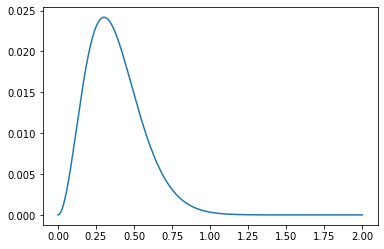

In [3]:
# CCL tracers
z = np.linspace(0., 2., 1000)
nz = z**2 * np.exp(-(z / 0.25)**1.5)
bz = 1 + z
ndens = 10.  # 10 gals per amin^2

# 3 tracers
gc = ccl.NumberCountsTracer(cosmo, False, (z,nz), (z, bz))
sh = ccl.WeakLensingTracer(cosmo, (z,nz))
ck = ccl.CMBLensingTracer(cosmo, 1100.)

# Noise power spectra
nl_gc = np.ones(n_ell) / (ndens * (60 * 180 / np.pi)**2)
nl_sh = np.ones(n_ell) * 0.28**2 / (ndens * (60 * 180 / np.pi)**2)

# Plot N(z)
plt.figure()
plt.plot(z, nz)
plt.show()


### Frequency maps
Now we create some information for the frequency map. Let's put it at some low frequency so that it is dominated by synchrotron, and we can ignore its cross-correlation with the LSS tracers.

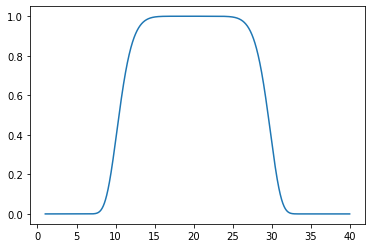

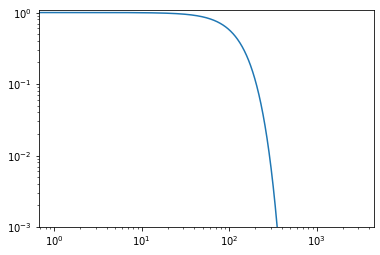

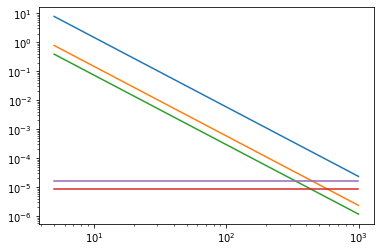

In [4]:
# Frequency bandpass
nu = np.linspace(1, 40, 2000)
bpass = np.exp(-((nu - 20.) / 10.)**8)
plt.figure()
plt.plot(nu,bpass)

# Beam
fwhm = 60.  # 3 arcmin
sigma = (fwhm / 2.355) * np.pi / 180 / 60
ell_beam = np.arange(3000)
beam = np.exp(-ell_beam * (ell_beam + 1) * sigma**2)
plt.figure()
plt.loglog(ell_beam, beam)
plt.ylim([1E-3,1.1])

# Noise power spectrum
sigma_T = 10.  # 10. uK arcmin
nl_tt = np.ones(n_ell) * (sigma_T * np.pi / 180 / 60) **2
nl_pp = 2 * nl_tt

# Signal power spectrum
cl_syn_tt = 0.01 * (ells / 80.)**(-2.4)
cl_syn_ee = 0.1 * cl_syn_tt
cl_syn_bb = 0.5 * cl_syn_ee
cl_syn_eb = 0.5 * cl_syn_bb
plt.figure()
plt.plot(ells, cl_syn_tt)
plt.plot(ells, cl_syn_ee)
plt.plot(ells, cl_syn_bb)
plt.plot(ells, nl_tt)
plt.plot(ells, nl_pp)
plt.loglog()
plt.show()

### Power spectra
Now let us generate all non-zero power spectra.

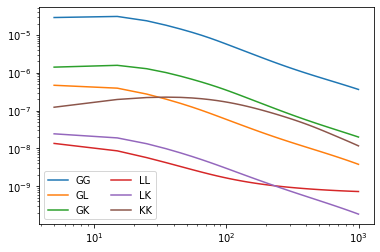

In [5]:
# Compute power spectra
# We will assume that the cross-correlation between clustering, lensing,
# and CMB lensing with the frequency maps is zero.
cls = np.zeros([n_maps, n_maps, n_ell])

plt.figure()
# GC - GC
cls[0, 0, :] = ccl.angular_cl(cosmo, gc, gc, ells) + nl_gc
plt.plot(ells, cls[0, 0, :], label='GG')

# GC - WL (E-only, B is zero)
cls[0, 1, :] = ccl.angular_cl(cosmo, gc, sh, ells)
cls[1, 0, :] = cls[0, 1, :]
plt.plot(ells, cls[0, 1, :], label='GL')

# GC - CMBK
cls[0, 3, :] = ccl.angular_cl(cosmo, gc, ck, ells)
cls[3, 0, :] = cls[0, 3, :]
plt.plot(ells, cls[0, 3, :], label='GK')

# WL - WL
# EE
cls[1, 1, :] = ccl.angular_cl(cosmo, sh, sh, ells) + nl_sh
# BB
cls[2, 2, :] = nl_sh
plt.plot(ells, cls[1, 1, :], label='LL')

# WL - CMBK (E-only, B is zero)
cls[1, 3, :] = ccl.angular_cl(cosmo, sh, ck, ells)
cls[3, 1, :] = cls[1, 3, :]
plt.plot(ells, cls[1, 3, :], label='LK')

# CMBK - CMBK
cls[3, 3, :] = ccl.angular_cl(cosmo, ck, ck, ells)
plt.plot(ells, cls[3, 3, :], label='KK')

# T - T
cls[4, 4, :] = cl_syn_tt
# E - E
cls[5, 5, :] = cl_syn_ee
# E - B
cls[5, 6, :] = cl_syn_eb
cls[6, 5, :] = cls[5, 6, :]
# B - B
cls[6, 6, :] = cl_syn_bb

plt.loglog()
plt.legend(loc='lower left', ncol=2)
plt.show()

### Bandpower window functions
For simplicity let's just assume top-hat windows

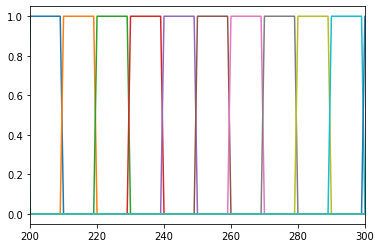

In [6]:
n_ell_large = 3001
ells_large = np.arange(n_ell_large)
window_single = np.zeros([n_ell, n_ell_large])
for i in range(n_ell):
    window_single[i, i * d_ell : (i + 1) * d_ell] = 1.

plt.figure()
for w in window_single:
    plt.plot(ells_large, w)
plt.xlim([200,300])
plt.show()

### Covariance
Finally, let's create a covariance matrix

In [7]:
fsky = 0.1
n_cross = (n_maps * (n_maps + 1)) // 2
covar = np.zeros([n_cross, n_ell, n_cross, n_ell])

id_i = 0
for i1 in range(n_maps):
    for i2 in range(i1, n_maps):
        id_j = 0
        for j1 in range(n_maps):
            for j2 in range(j1, n_maps):
                cl_i1j1 = cls[i1, j1, :]
                cl_i1j2 = cls[i1, j2, :]
                cl_i2j1 = cls[i2, j1, :]
                cl_i2j2 = cls[i2, j2, :]
                # Knox formula
                cov = (cl_i1j1 * cl_i2j2 + cl_i1j2 * cl_i2j1) / (d_ell * fsky * (2 * ells + 1))
                covar[id_i, :, id_j, :] = np.diag(cov)
                id_j += 1
        id_i += 1
covar = covar.reshape([n_cross * n_ell, n_cross * n_ell])

## Create SACC file

We start by creating an empty `Sacc` object.

In [8]:
s = sacc.Sacc()

### Tracers
Now we add all maps as individual tracers.
The GC and WL maps will be `NZ` tracers, the CMBK tracer will be a `Map` tracer, and the I/Q/U maps will be two `NuMap` tracers (one for temperature, another one for polarization).

In [9]:
# GC
s.add_tracer('NZ', 'gc',  # Name
             quantity='galaxy_density',  # Quantity
             spin=0,  # Spin
             z=z,  # z
             nz=nz)  # nz
# WL
s.add_tracer('NZ', 'wl',  # Name
             quantity='galaxy_shear',  # Quantity
             spin=2,  # Spin
             z=z,  # z
             nz=nz,  # nz
             extra_columns={'error': 0.1*nz},  # You can include extra columns for the N(z)
             sigma_g=0.28)  # You can add any extra information as **kwargs
# CMBK
s.add_tracer('Map', 'ck',  # Name
             quantity='cmb_convergence',  # Quantity
             spin=0,  # Spin
             ell=ell_beam, beam=beam)  # Beam

# T
s.add_tracer('NuMap', 'B20_T',  # Name
             quantity='cmb_temperature',  # Quantity
             spin=0,  # Spin
             nu=nu, bandpass=bpass,  # Bandpass
             bandpass_extra={'error': 0.01 * bpass},  # You can add some extra bandpass data.
             ell=ell_beam, beam=beam,  # Beam
             beam_extra={'error': 0.01 * beam},
             nu_unit='GHz',  # Frequency units
             map_unit='uK_RJ',  # Map units
            )

# Q/U
s.add_tracer('NuMap', 'B20_P',  # Name
             quantity='cmb_polarization',  # Quantity
             spin=2,  # Spin
             nu=nu, bandpass=bpass,  # Bandpass
             bandpass_extra={'error': 0.01 * bpass},  # You can add some extra bandpass data.
             ell=ell_beam, beam=beam,  # Beam
             beam_extra={'error': 0.01 * beam},
             nu_unit='GHz',  # Frequency units
             map_unit='uK_RJ',  # Map units
            )

### Power spectra
Now we add all power spectra one-by-one

In [10]:
# Create a SACC bandpower window object
wins = sacc.BandpowerWindow(ells_large, window_single.T)
# GC-GC
s.add_ell_cl('cl_00',  # Data type
             'gc',  # 1st tracer's name
             'gc',  # 2nd tracer's name
             ells,  # Effective multipole
             cls[0, 0, :],  # Power spectrum values
             window=wins,  # Bandpower windows
            )
# GC-WL
s.add_ell_cl('cl_0e', 'gc', 'wl', ells, cls[0, 1, :], window=wins)
s.add_ell_cl('cl_0b', 'gc', 'wl', ells, cls[0, 2, :], window=wins)
# GC-CMBK
s.add_ell_cl('cl_00', 'gc', 'ck', ells, cls[0, 3, :], window=wins)
# GC-T
s.add_ell_cl('cl_00', 'gc', 'B20_T', ells, cls[0, 4, :], window=wins)
# GC-P
s.add_ell_cl('cl_0e', 'gc', 'B20_P', ells, cls[0, 5, :], window=wins)
s.add_ell_cl('cl_0b', 'gc', 'B20_P', ells, cls[0, 6, :], window=wins)
# WL-WL
s.add_ell_cl('cl_ee', 'wl', 'wl', ells, cls[1, 1, :], window=wins)
s.add_ell_cl('cl_eb', 'wl', 'wl', ells, cls[1, 2, :], window=wins)
s.add_ell_cl('cl_bb', 'wl', 'wl', ells, cls[2, 2, :], window=wins)
# WL-CMBK
s.add_ell_cl('cl_0e', 'wl', 'ck', ells, cls[1, 3, :], window=wins)
s.add_ell_cl('cl_0b', 'wl', 'ck', ells, cls[2, 3, :], window=wins)
# WL-T
s.add_ell_cl('cl_0e', 'wl', 'B20_T', ells, cls[1, 4, :], window=wins)
s.add_ell_cl('cl_0b', 'wl', 'B20_T', ells, cls[2, 4, :], window=wins)
# WL-E/B
s.add_ell_cl('cl_ee', 'wl', 'B20_P', ells, cls[1, 5, :], window=wins)
s.add_ell_cl('cl_eb', 'wl', 'B20_P', ells, cls[1, 6, :], window=wins)
s.add_ell_cl('cl_be', 'wl', 'B20_P', ells, cls[2, 5, :], window=wins)
s.add_ell_cl('cl_bb', 'wl', 'B20_P', ells, cls[2, 6, :], window=wins)
# CMBK-CMBK
s.add_ell_cl('cl_00', 'ck', 'ck', ells, cls[3, 3, :], window=wins)
# CMBK-T
s.add_ell_cl('cl_00', 'ck', 'B20_T', ells, cls[3, 4, :], window=wins)
# CMBK-P
s.add_ell_cl('cl_0e', 'ck', 'B20_P', ells, cls[3, 5, :], window=wins)
s.add_ell_cl('cl_0b', 'ck', 'B20_P', ells, cls[3, 6, :], window=wins)
# T-T
s.add_ell_cl('cl_00', 'B20_T', 'B20_T', ells, cls[4, 4, :], window=wins)
# T-P
s.add_ell_cl('cl_0e', 'B20_T', 'B20_P', ells, cls[4, 5, :], window=wins)
s.add_ell_cl('cl_0b', 'B20_T', 'B20_P', ells, cls[4, 6, :], window=wins)
# P-P
s.add_ell_cl('cl_ee', 'B20_P', 'B20_P', ells, cls[5, 5, :], window=wins)
s.add_ell_cl('cl_eb', 'B20_P', 'B20_P', ells, cls[5, 6, :], window=wins)
s.add_ell_cl('cl_bb', 'B20_P', 'B20_P', ells, cls[6, 6, :], window=wins)

### Covariance
Finally, add the covariance

In [11]:
s.add_covariance(covar)

### Writing
Finally, write it to file!

In [12]:
s.save_fits("cmblss.fits", overwrite=True)